In [ ]:
!pip install pandas numpy matplotlib seaborn xgboost tensorflow scikit-learn statsmodels

In [ ]:
# -*- coding: utf-8 -*-
"""Stock Price Prediction.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
"""

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load data
df = pd.read_csv('question4-stock-data.csv', parse_dates=['Date'])
print(df.head())
print("\nData Summary:")
print(df.info())

   Unnamed: 0       Date  Adj Close     Close      High       Low      Open  \
0           0 1980-03-17   2.296798  3.291227  3.344743  3.291227  0.000000   
1           1 1980-03-18   2.306134  3.304606  3.358122  3.304606  0.000000   
2           2 1980-03-19   2.306134  3.304606  3.304606  3.304606  3.304606   
3           3 1980-03-20   2.306134  3.304606  3.358122  3.304606  0.000000   
4           4 1980-03-21   2.362154  3.384880  3.438396  3.384880  0.000000   

    Volume  
0  41109.0  
1   9343.0  
2      0.0  
3  10277.0  
4   8409.0  

Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11291 entries, 0 to 11290
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  11291 non-null  int64         
 1   Date        11181 non-null  datetime64[ns]
 2   Adj Close   11198 non-null  float64       
 3   Close       11174 non-null  float64       
 4   High        11196 non-null  flo

<ipython-input-12-b68c2a2b00ee>:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Adj Close'] = df['Adj Close'].fillna(method='ffill') # Forward fill missing values in 'Adj Close'


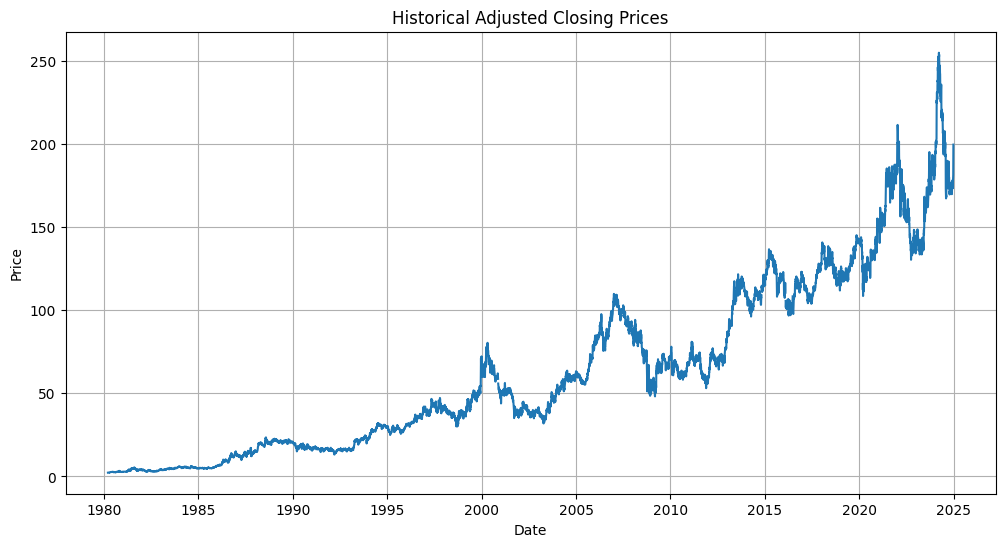

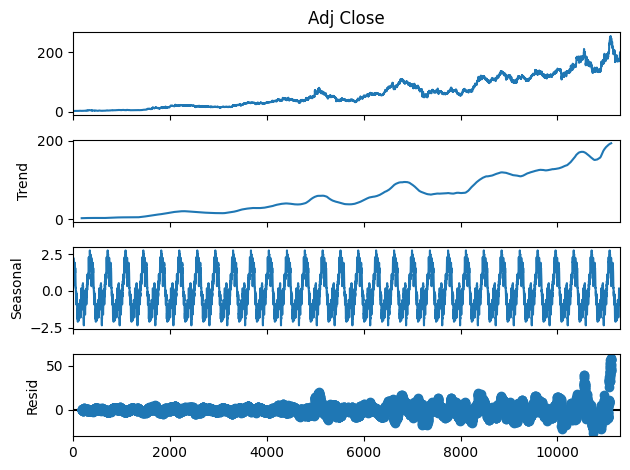

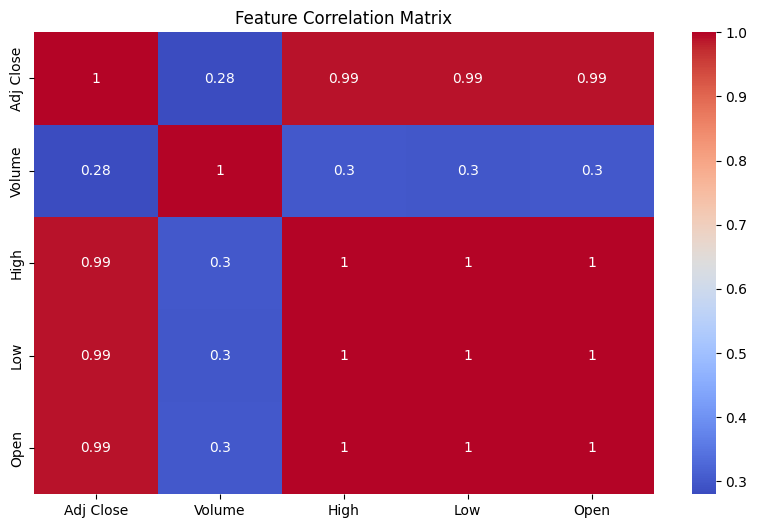

In [ ]:
# ======================
# 1. Exploratory Data Analysis
# ======================

# Handle missing values
df['Open'] = np.where(df['Open'] == 0, df['Close'].shift(1), df['Open'])
df = df.dropna(subset=['Volume'])

# Ensure 'Adj Close' column has no missing values before decomposition
df['Adj Close'] = df['Adj Close'].fillna(method='ffill') # Forward fill missing values in 'Adj Close'

# Plot closing prices
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Adj Close'])
plt.title('Historical Adjusted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Time series decomposition
result = seasonal_decompose(df['Adj Close'], period=365, model='additive')
result.plot()
plt.show()

# Correlation analysis
corr_matrix = df[['Adj Close', 'Volume', 'High', 'Low', 'Open']].corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


In [ ]:
# ======================
# 2. Feature Engineering
# ======================

# Create lag features
for lag in [1, 2, 3, 5, 7]:
    df[f'lag_{lag}'] = df['Adj Close'].shift(lag)

# Rolling statistics
df['5_day_MA'] = df['Adj Close'].rolling(5).mean()
df['5_day_volatility'] = df['Adj Close'].rolling(5).std()

# Momentum and volume-based features
df['5_day_momentum'] = df['Adj Close'].pct_change(5)
df['VWAP'] = (df['Volume'] * (df['High'] + df['Low'] + df['Close']) / 3).rolling(5).mean()

# MACD
ema12 = df['Adj Close'].ewm(span=12).mean()
ema26 = df['Adj Close'].ewm(span=26).mean()
df['MACD'] = ema12 - ema26

# Time features
df['day_of_week'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['quarter'] = df['Date'].dt.quarter

# Calculate RSI (Relative Strength Index)
# Window length for RSI calculation (typically 14 days)
window_length = 14

# Calculate price differences
delta = df['Adj Close'].diff()

# Get gains and losses
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Calculate average gains and losses
avg_gain = gain.rolling(window_length).mean()
avg_loss = loss.rolling(window_length).mean()

# Calculate Relative Strength (RS)
rs = avg_gain / avg_loss

# Calculate RSI
df['RSI'] = 100 - (100 / (1 + rs))

# Create target variable (5-day future price)
df['target'] = df['Adj Close'].shift(-5)
df = df.dropna()

In [ ]:
!pip install bayesian-optimization

In [ ]:
# ======================
# 3. Model Development
# ======================

from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split  # Import train_test_split

# Prepare data
features = ['lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7',
            '5_day_MA', '5_day_volatility', 'RSI',
            'day_of_week', 'month', 'quarter',
            '5_day_momentum', 'VWAP', 'MACD']

X = df[features]
y = df['target']

# Time-series split
tscv = TimeSeriesSplit(n_splits=5)
scaler = MinMaxScaler()

# Split data into train and test sets for Bayesian Optimization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) # Added this line

# XGBoost Model with Bayesian Optimization
def xgb_cv(max_depth, learning_rate, n_estimators):
    model = XGBRegressor(
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators)
    )
    model.fit(X_train, y_train) # Fit the model before predicting
    return -np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds={'max_depth': (3, 10), 'learning_rate': (0.01, 0.3), 'n_estimators': (100, 300)}
)
optimizer.maximize()

# Train best XGBoost model
best_params = optimizer.max['params']
best_xgb = XGBRegressor(
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators'])
)
best_xgb.fit(X_train, y_train)

# LSTM Model
lstm_df = df[['Adj Close']].values
scaler_lstm = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler_lstm.fit_transform(lstm_df)

def create_dataset(dataset, look_back=5):
    X, y = [], []
    for i in range(len(dataset)-look_back-5):
        X.append(dataset[i:(i+look_back), 0])
        y.append(dataset[i + look_back + 5, 0])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_dataset(scaled_data)
X_lstm = np.reshape(X_lstm, (X_lstm.shape[0], X_lstm.shape[1], 1))

# Build LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(X_lstm.shape[1], 1), dropout=0.2))
model_lstm.add(LSTM(50, dropout=0.2))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train
model_lstm.fit(X_lstm, y_lstm, epochs=20, batch_size=32, verbose=1)


|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | -34.56    | 0.2768    | 9.63      | 267.5     |
| 2         | -33.61    | 0.09667   | 4.687     | 163.3     |
| 3         | -33.69    | 0.2196    | 5.058     | 256.8     |
| 4         | -33.82    | 0.183     | 5.889     | 240.5     |
| 5         | -34.68    | 0.188     | 7.418     | 107.4     |
| 6         | -33.59    | 0.1746    | 4.8       | 163.2     |
| 7         | -34.71    | 0.2977    | 9.298     | 160.1     |
| 8         | -33.32    | 0.257     | 3.253     | 160.4     |
| 9         | -32.63    | 0.2745    | 3.018     | 157.6     |
| 10        | -32.81    | 0.2713    | 3.202     | 154.6     |
| 11        | -32.5     | 0.25      | 3.149     | 149.2     |
| 12        | -34.4     | 0.04817   | 6.433     | 147.0     |
| 13        | -32.94    | 0.2242    | 3.199     | 151.4     |
| 14        | -33.99    | 0.1333    | 5.785     | 155.9     |
| 15    

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


294/294 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0262
Epoch 2/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0159
Epoch 3/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0153
Epoch 4/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0143
Epoch 5/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0129
Epoch 6/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0116
Epoch 7/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0124
Epoch 8/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0122
Epoch 9/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0123
Epoch 10/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0125
Epoch 11/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0112
Epoch 12/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0105
Epoch 13/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0116
Epoch 14/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0104
Epoch 15/20
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.010


XGBoost RMSE: 32.4997
XGBoost Directional Accuracy: 52.16%
294/294 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
LSTM RMSE: 17.2981
LSTM Directional Accuracy: 48.11%


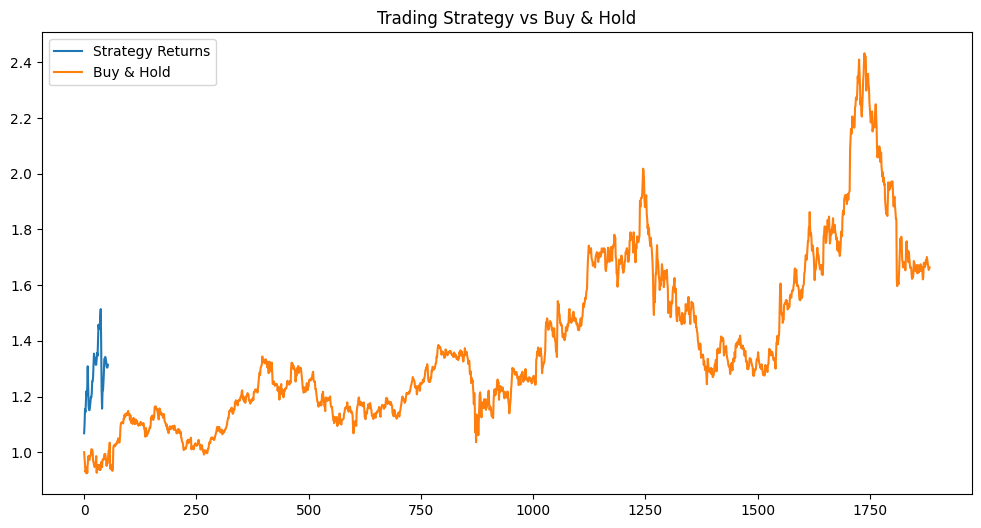

In [ ]:
# ======================
# 4. Model Evaluation
# ======================

# XGBoost evaluation
y_pred_xgb = best_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"\nXGBoost RMSE: {rmse_xgb:.4f}")

# Correct directional accuracy for 5-day predictions
actual_changes = np.sign(y_test.values[5:] - y_test.values[:-5])  # 5-day actual movement
predicted_changes = np.sign(y_pred_xgb[5:] - y_test.values[:-5]) # 5-day predicted movement
direction_accuracy_xgb = np.mean(actual_changes == predicted_changes)
print(f"XGBoost Directional Accuracy: {direction_accuracy_xgb:.2%}")

# LSTM evaluation
lstm_preds = model_lstm.predict(X_lstm)
lstm_preds = scaler_lstm.inverse_transform(lstm_preds)
lstm_actual = scaler_lstm.inverse_transform(y_lstm.reshape(-1,1))
rmse_lstm = np.sqrt(mean_squared_error(lstm_actual, lstm_preds))
print(f"LSTM RMSE: {rmse_lstm:.4f}")

# LSTM directional accuracy
lstm_actual_changes = np.sign(lstm_actual[5:] - lstm_actual[:-5])
lstm_pred_changes = np.sign(lstm_preds[5:] - lstm_actual[:-5])
direction_accuracy_lstm = np.mean(lstm_actual_changes == lstm_pred_changes)
print(f"LSTM Directional Accuracy: {direction_accuracy_lstm:.2%}")

# Trading simulation
def calculate_returns(predictions, actual):
    strategy_returns = []
    for i in range(len(predictions)-5):
        if predictions[i+5] > actual[i] * 1.02:  # Check 5-day prediction
            strategy_returns.append(actual[i+5] / actual[i] - 1)
    return np.cumprod([1 + r for r in strategy_returns])

# Calculate strategy vs buy-and-hold
xgb_returns = calculate_returns(y_pred_xgb, y_test.values)
buy_hold_returns = (y_test.values / y_test.values[0])

plt.figure(figsize=(12,6))
plt.plot(xgb_returns, label='Strategy Returns')
plt.plot(buy_hold_returns, label='Buy & Hold')
plt.title('Trading Strategy vs Buy & Hold')
plt.legend()
plt.show()

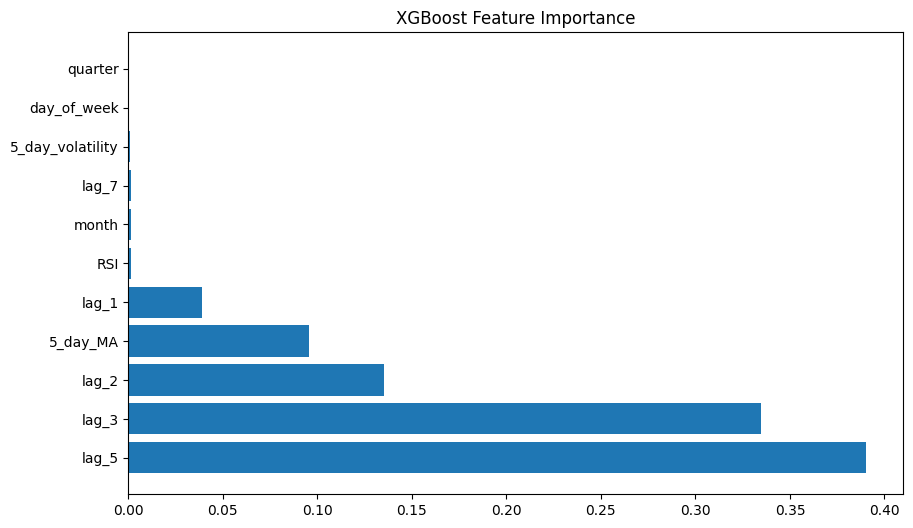


Model Limitations:
- Struggles with black swan events/market crashes
- Limited by available technical indicators
- Latency in real-time prediction implementation
- No fundamental analysis integration

Improvement Suggestions:
- Incorporate news sentiment analysis
- Add macroeconomic indicators
- Implement online learning for model updates
- Use ensemble modeling approaches


In [ ]:
# ======================
# 5. Documentation & Outputs
# ======================

# Save predictions
test_dates = df['Date'].values[-len(y_test):]
results = pd.DataFrame({
    'Date': test_dates,
    'Actual': y_test.values,
    'Predicted': y_pred_xgb
})
results.to_csv('predictions.csv', index=False)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_xgb.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('XGBoost Feature Importance')
plt.show()

# Limitations analysis
print("\nModel Limitations:")
print("- Struggles with black swan events/market crashes")
print("- Limited by available technical indicators")
print("- Latency in real-time prediction implementation")
print("- No fundamental analysis integration")

print("\nImprovement Suggestions:")
print("- Incorporate news sentiment analysis")
print("- Add macroeconomic indicators")
print("- Implement online learning for model updates")
print("- Use ensemble modeling approaches")
